# Popular Data Science Questions

# Project's Goal

One of the things companies are always looking for is to know what their customers want. In this sense, companies in the business of teaching data science will find themselces asking **"what's the best product I can produce to my customers?"**. This project aims to tackle this question.

Since the word "best" might conveys different meanings, we can change the question to **"what is it that people want to know about data science?"**. This will ensure for the companies that the content produced meets the expectations of the customers.

# Considerations on the Data

A good place to find out what people interested in Data Science are talking about is stack exchange. In every website of the stack exchange group, people are able to post questions and answer then, which seems very promising when it comes to finding out what are the hot topics among its users. 

A lot of the data about the posts on stack exchange is available through [Stack Exchange Data Explorer (SEDE)](https://data.stackexchange.com/meta.stackexchange/query/edit/1241209).

There are inumerous information on posts that can be analyzed, but we'll focus on the following columns:

1) ID

2) CreationDate

3) Score

4) ViewCount

5) Tags

6) AnswerCount

7) FavouriteCount


Also, the results are filtered to one single post type (there are 8 in total, but the most relevant ones are question posts, which carry the PostTypeId 1). As mentioned, we're also only considering posts from 2019. 

### Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import datetime

## Overview of the Dataset

Below there is a small sample of the data, so that we can better understand how the data in our hands looks like.

In [2]:
stack = pd.read_csv(r"C:\Users\celio\Data Analysis\Projects\Popular Data Science Questions\stack_exchange_query_results.csv")
stack.head(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,53165,2019-06-04 05:20:25,1,24,<python><pandas>,0,NaN
1,53167,2019-06-04 06:58:26,0,27,<learning-rate><generalization>,0,1.0
2,53169,2019-06-04 07:38:01,0,30,<scikit-learn><naive-bayes-classifier>,0,NaN


A overall description of the values in each column can be seen below.

In [3]:
stack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283 entries, 0 to 8282
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8283 non-null   int64  
 1   CreationDate   8283 non-null   object 
 2   Score          8283 non-null   int64  
 3   ViewCount      8283 non-null   int64  
 4   Tags           8283 non-null   object 
 5   AnswerCount    8283 non-null   int64  
 6   FavoriteCount  1500 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 453.1+ KB


It jumps immediatelly to the eye that the CreationDate does not has the right data type. It contains dates, but its entries are in string format. Moreover, the Tags column contains characters that make data manipulation and extraction from meaningful insights harder.

Last but not least, there are many missing values in the FavoriteCount column, 6.783 to be more precise.

## Investigating Missing Values

Since we know there are missing values, we can investigate if there is any pattern to them. This can be seen below*:

\* Pink lines or bars represent the missing values.

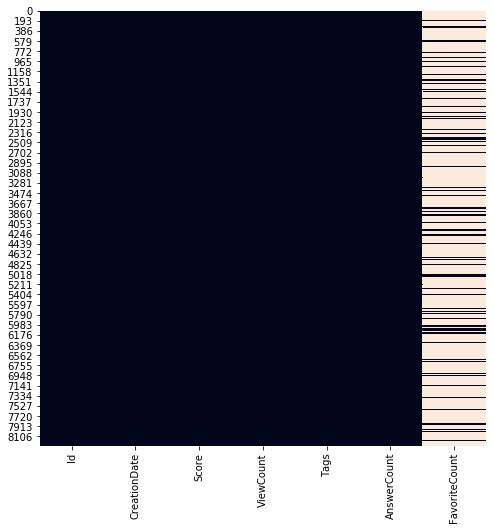

In [4]:
plt.figure(figsize=(8,8))
sns.heatmap(data=stack.isnull(),cbar=False)

There does not seem to be a pattern for the missing data in any of the columns nor does it seem to be related to another column in the dataset. 

By experience, we know that most posts in Data Science Stack Exchange have a favorite count of 0. However, before we substitute the missing values, we can check if there isn't a better statistical metric.

### Filling Missing Values

In order to choose which value we should use to replace the missing ones, it's necessary to check how they are distributed across the FavoriteCount column. 

The nummerical distribution of the FavoriteCount column can be seen below:

In [5]:
stack["FavoriteCount"].describe()

count    1500.000000
mean        1.263333
std         1.133216
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: FavoriteCount, dtype: float64

The output above indicates the 75% of the posts have 1 favorite vote or less. The mean, 1.26, is pulled upwards by the very few posts with a large number of favorites.

The Visual representation of this:

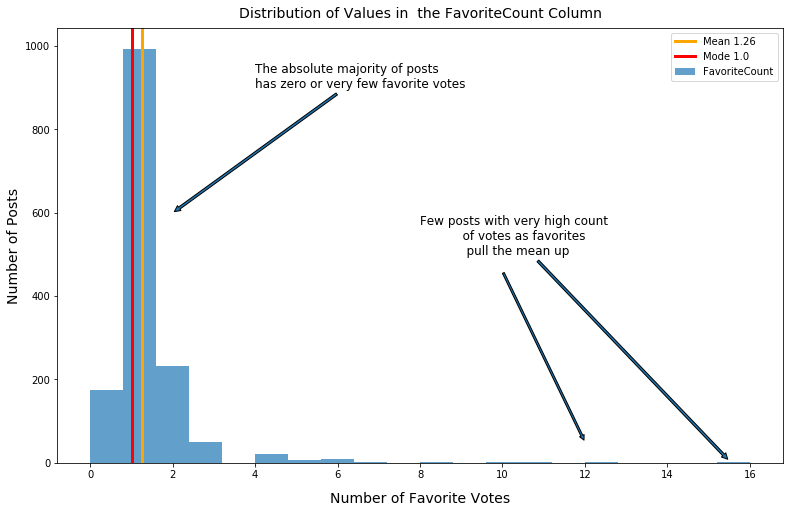

In [6]:
stack["FavoriteCount"].plot.hist(figsize=(13,8), bins = 20, alpha= 0.7)
plt.title("Distribution of Values in  the FavoriteCount Column", fontsize="14",pad=10)
plt.xlabel("Number of Favorite Votes", fontsize="14",labelpad=12)
plt.ylabel("Number of Posts",fontsize="14")

plt.annotate("The absolute majority of posts\nhas zero or very few favorite votes",xy= (2,600),xytext=(4,900),
            fontsize="12", arrowprops={"arrowstyle":"simple"}, color = "black")

# plt.annotate("        94\n(highest number\nof favorite votes)",xytext =(80,1000),xy=(80,5),
#             fontsize="12",arrowprops={"arrowstyle":"simple"},color = "black")

plt.axvline(stack["FavoriteCount"].mean(), color = "orange", linewidth=3, 
            label = "Mean {}".format(str(round(stack["FavoriteCount"].mean(),2))))

plt.axvline(stack["FavoriteCount"].mode()[0], label = "Mode {}".format(stack["FavoriteCount"].mode()[0]),
           color = "red",linewidth=3)

plt.annotate("Few posts with very high count\n           of votes as favorites\n            pull the mean up",
             xytext=(8,500),xy=(15.5,5),
            fontsize="12", arrowprops={"arrowstyle":"simple"})
plt.annotate("",xy=(12,50), xytext=(10,460),arrowprops={"arrowstyle":"simple"})

plt.legend()
plt.show()

Looking at the chart above, we have to remember the lesson from Alvira Swalin, from Towards Data Science, there is [no perfect way to deal with missing data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4). 

Trying to replace the missing values with the mean would be missleading, because the distribution in the column FavoriteCount is heavily skewed to the right. On top of this, replacing it by the mode would go totally against our intuition and experience, which says that most posts in Data Science Stark Overflow have a favorite count of 0. 

For these reasons, we'll rely on our knowledge of the data source to substitute the missing values in FavoriteCount column with 0s, but keep in mind that the data might not accurate.

In [7]:
stack.loc[stack["FavoriteCount"].isnull(),"FavoriteCount"]= 0

## The Tags Column

This column is important, because it conveys the information on which were the prefered topics of people involved with data science. Nevertheless, in order to analyse it properly, it has to be cleaned first.

In [8]:
stack["Tags"] = stack["Tags"].str.replace("<","").str.replace(">",",").str.rstrip(",")

## Most Commented Tags

Now that the data is cleaner, we can investigate which topics attract the most attention by users of the website. 

There are many strategies to proceed this task, for example, measure the prefered topics by the FavoriteCount or by the number of answers. However, as we've seen, the number of favorite votes isn't very reliable. As for the number of answers, it's highly influenced by the quality of the question asked, which isn't a variable present in the dataset.

Therefore, we'll proceed the analysis by verifying which are the most common tags and also verify the number of views for each tag. 

In [9]:
# Creating a DataFrame only with the information contained in tags
tags = stack["Tags"].str.split(",",expand=True) # THIS WILL BE USED LATER FOR FURTHER DATA MANIPULATION
tag_list = []
def count_tags(value):
    if value != None:
        tag_list.append(value)
        
for column in tags.columns:
    tags[column].apply(count_tags)

tag_series = pd.Series(tag_list)
tag_series.value_counts().sort_values(ascending = False).head(20).reset_index().rename(columns ={"index":"tags",
                                                                                                0:"values"})

,tags,values
0,machine-learning,2544
1,python,1709
2,deep-learning,1134
3,neural-network,1005
4,keras,876
5,classification,649
6,tensorflow,544
7,scikit-learn,509
8,nlp,464
9,cnn,458


In the DataFrame above, we can see the 20 most common topics on Data Science Stack Exchange. We can make the result a bit more attractive to the eye by plotting the following chart:

In [10]:
tag_count = tag_series.value_counts().sort_values(ascending = False).head(20).reset_index()
tag_count.columns = ["tags","values"]
tag_count

tag_count_chart = alt.Chart(tag_count).mark_bar().encode(
    x= alt.X("values", axis = alt.Axis(labelFontSize=12, titleFontSize=12,title = "Number of Times Commented")),
    y= alt.Y("tags", axis= alt.Axis(labelFontSize=12, title = "Tag", titleFontSize=12)),
    color = "tags")

tag_count_text = tag_count_chart.mark_text(align = "left",
                                          baseline= "middle",
                                          dx = 3).encode(
                                            text = "values")

(tag_count_chart+tag_count_text).configure_axis(
    grid=False).configure_view(strokeWidth=0).properties(
    width=650,height = 500, title = "Number of Comments By Tag")

alt.LayerChart(...)

The Number 20 is a quite arbitrary, but it should provide enough information for the company on which contents to produce, even though some tags are very broad, like "python", "dataset" or "statistics".

# Tags With Most Views

To validate the results above, we can match them against them the most viewed tags (before we counted how many times every tag was mentioned). For this, we will use the ViewCount column from the main DataFrame.

In [12]:
                                    """" This Part Could Use Some Otimization"""

most_views = pd.concat([tags,stack["Id"]], axis = 1) # This binds the DF with the Tags (which appeared after the
                                                    # string operation) to the ID columns of the main DF

most_views = most_views.melt(id_vars = "Id",value_vars = [0,1,2,3,4], # This transforms DF from wide to long format
                            value_name = "tags").sort_values("tags") # Important to sort values by tag 

# In the process of extracting the tags, some None values appeared in the tags DF. We have to work around them
 
for i,c in enumerate(most_views["tags"]): # The column has to be sorted at this point, or it won't work
    
    """" Since the column is sorted by values, we can iterate through the column and get the index of
    of the first row which presents a None value. All other rows will also present None values (because it's sorted) 
    and can therefore be excluded from the dataset""" 
    
    if c is None: # Funny thing about None, it does not work well with equality operators, but better with identity ones
        print(i,c) # This shows where we have to cut the dataset
        cut_point = i
        break # Breaks the loop (as soon asthe first none is found, we don't need any other information)
        
most_views = most_views.iloc[:cut_point,:] # This slices the DataFrame

#     """For the last part we merge the most_views DF with the ViewCount columns of the stack DataFrame.
#     By choosing left as join method the Values of the ViewCount columns will be propagated to any matching 'keys'
#     on the Id column"""

most_views = pd.merge(left = most_views,right = stack[["Id","ViewCount"]], left_on = "Id",right_on = "Id", how = "left")

#     """Now, finally, we can use a pivot table to find out which are the tags with the most views"""

# The code below groups the dataframe by the values in the tags columns and sets those values as the index
# Then it applies the sum function to the ViewCount column, so that we get how many times a tag was viewed. 
pivot_views = most_views.pivot_table(values = "ViewCount",index = "tags",aggfunc = "sum").sort_values("ViewCount",
                                                                                                      ascending=False)
pivot_views.head(20)

#                             """This code is very verbose, but it does the trick.
#                             There is sure another way to do what I did, but you
#                             simply cannot not love pandas for allowing all this =) """

25019 None


,ViewCount
tags,
python,1036280
machine-learning,679138
keras,474111
pandas,448866
deep-learning,397576
neural-network,326587
scikit-learn,242552
tensorflow,224417
classification,181674


A visual representation of the output above is:

In [13]:
views_chart =alt.Chart(pivot_views.reset_index().head(20)).mark_bar().encode(
    x= alt.X("ViewCount",title = "Number of Views", 
             axis = alt.Axis(title = "Number of Views",titleFontSize=12, labelFontSize=12)),
    
    y=alt.Y("tags", axis = alt.Axis(title = "Tag", titleFontSize=12, labelFontSize=12)),
    
    color = "tags")

views_text = views_chart.mark_text(align="left",
                     baseline="middle",
                     dx=3).encode(
                text = "ViewCount")

(views_chart+views_text).configure_view(
    strokeWidth=0).configure_axis(
    grid=False).properties(
    width=680, title = "Number of Views By Tag")

alt.LayerChart(...)

# Comparing Results

We can compare the results by merging the DataFrames together. 

In [14]:
comparison = pd.merge(left = most_views[["tags","ViewCount"]].sort_values("ViewCount",
                                                             ascending = False).head(20),
        right = tag_count.head(20),
                      
        on = "tags", how ="outer").rename(
    columns = {"tags":"tags",
               "ViewCount": "is_most_commented",
               "values":"is_most_viewed"})[["tags","is_most_commented","is_most_viewed"]].drop_duplicates(
    "tags").fillna(False)
comparison.loc[comparison["is_most_commented"]!=False,"is_most_commented"] = True
comparison.loc[comparison["is_most_viewed"]!=False,"is_most_viewed"] = True
    
comparison["is_in_both"] = comparison["is_most_commented"]+comparison["is_most_viewed"]
comparison["is_in_both"] = comparison["is_in_both"].replace({2:True,1:False})
comparison

,tags,is_most_commented,is_most_viewed,is_in_both
0,python,True,True,True
3,pandas,True,True,True
7,csv,True,False,False
8,dataframe,True,False,False
9,data-formats,True,False,False
10,machine-learning,True,True,True
12,classification,True,True,True
13,deep-learning,True,True,True
14,keras,True,True,True
15,neural-network,True,True,True


Below, we see a summarized table containing only tags present both in the group of most commented and in the group of most viewed.


In [15]:
comparison[comparison["is_in_both"]==True]

,tags,is_most_commented,is_most_viewed,is_in_both
0,python,True,True,True
3,pandas,True,True,True
10,machine-learning,True,True,True
12,classification,True,True,True
13,deep-learning,True,True,True
14,keras,True,True,True
15,neural-network,True,True,True
17,scikit-learn,True,True,True


The table above shows which topics are the most popular ones among users interested in Data Science. While further research is theoretically possible to find out how these topics are [associated with each other](https://en.wikipedia.org/wiki/Association_rule_learning), this would be certainly out of the scope of this project.

On the other hand, by experience, we know that python and pandas often appear together, so they fall unter the same category. The same goes for "deep leaning","keras","neural-network" and "scikit-learn", which are all related to machine learning.

We can check how those two major categories, python and machine learning, perform over time, to confirm or reject this supposition. The classification tag will be left out of further analysis, because it's too generic.

# Evaluating Trends Over Time

One way to understand how every tag performed over time is to match them against the average performance of the other tabs.

In [16]:
                                    """The Code to Rule Them All"""

                                    """Additional Data Cleaning"""
        
stack["CreationDate"] = pd.to_datetime(stack["CreationDate"]) # Changes format of CreationDate column to datetime
tags = stack["Tags"].str.split(",", expand =True) # Splits the Tags column and generates DataFrame

#                                         """Data Manipulation"""
    
tags = pd.concat([stack,tags],axis =1) # Concatenates Tags and Original DataFrame
# This transforms DataFrame from wide to long format and then sort values by tags (this is to count values better)
melted_tags = tags.melt(id_vars = ["Id","CreationDate"],value_vars = [0,1,2,3,4], value_name="tags").sort_values("tags")
for i,c in enumerate(melted_tags["tags"]): # Iterates through melted_tags column to find out where None values are
    if c is None: # This loop iterates the column until it finds the first None value, than it breaks
        cut = i
        break # Break, because no further research is necessary and index is already attributed to cut variable
melted_tags = melted_tags.iloc[:cut,:] # uses cut variables to slice DataFrame
# Creates new column with month and year (to serve as a parameter for future grouping)
melted_tags["date"] = melted_tags["CreationDate"].dt.month*100+melted_tags["CreationDate"].dt.year-2000
 
# Creates a DataFrame only containing information related to python and pandas tags
python_pandas = melted_tags.loc[(melted_tags["tags"]=="python")|(melted_tags["tags"]=="pandas")]
# Group by data and reset index (this will allow for ploting later)
python_pandas = python_pandas.groupby("date").count().reset_index()[["date","tags"]] # Selects only useful columns
python_pandas.columns = ["date","times_mentioned"] # rename columns (tags column cointained how many times the was mentioned)
python_pandas["tag"] = "python_pandas" # create additional column containing the name of the tag

machine_learning_topics = ["deep-learning","keras","neural-network","scikit-learn","machine-learning"] # List with ML topics

machine_learning_dict = {} # Dictionary to store results

for topic in machine_learning_topics: # Loops through the values of machine_learning_topics list
    machine_learning_dict[topic] = melted_tags[melted_tags["tags"]==topic] # For every key in dict, a corresponding DF
    # Sets DFs to the same format of python pandas (groupby,reset_index,rename columns)
    machine_learning_dict[topic] = machine_learning_dict[topic].groupby(
        "date").count().reset_index().rename(columns = {"tags":"times_mentioned"})[["date","times_mentioned"]]
    
all_tags = pd.concat(machine_learning_dict) # concatenate DFs in machine_learning_dict
all_tags = all_tags.reset_index().rename(columns={"level_0":"tag"})[["date","times_mentioned","tag"]] #renames columns
all_tags = pd.concat([python_pandas,all_tags]) # concatenates python_pandas and Dfs from machine_learning_dict
all_tags["average_comments_tag"] =melted_tags["tags"].value_counts().mean()# Adds another row with the average comment count

#                                                 """Plotting Charts
#                                         (At this point, I'm glad I used altair. It
#                                         would have been even longer with matplotlib)"""
    
base = alt.Chart(all_tags).properties(width=750, title = "Number of Comments By Tag in 2019") # Sets up a base chart

lines = base.mark_line().encode(
    x= alt.X("date", axis = alt.Axis(title= "Date (MYY)",titleFontSize=12,
                                     values = [119,219,319,419,519,619,719,819,919,1019,1119,1219])),
    y= alt.Y("times_mentioned", axis = alt.Axis(title = "Number of Comments", titleFontSize=12)),
    color = "tag") # Chart With Lines To Show how tags performed across time

line_text = lines.mark_text(align = "left",
                                    baseline = "middle",
                                    dx=3).encode(text= "times_mentioned") # Annotates the Lines


rule = base.mark_rule().encode(
    y="average(average_comments_tag)")

rule_text = rule.mark_text(align="left",baseline="line-bottom",dx=230).encode(text="average(average_comments_tag)")



(lines+line_text)+(rule+rule_text)

alt.LayerChart(...)

The output above makes it clear that the topics "deep-learning","keras","machine-learning","neural-network"and "python-pandas" had an above average interest for the users of the Data Science Stack Exchange website. In the chart above, they were every month located above the average number of comments a tag had (black line).

The exception is scikit-learn, which performed like the average.

# Conclusion

In this project, we analyzed data from Data Science Stack Exchange, in order to indicate to a company which content it should produce, according to the interest of people interested in Data Science.

Two strategies were used. First, we found out which were the most common tags in the website. After this, we found out which tags were the most viewed. The tags **"deep-learning","keras","machine-learning","neural-network", "scikit-learn" and "python-pandas"** were present in both results.

Finally, to ensure that these topics had relevance over time, we analyzed the popularity of the tags across the whole year of 2019. At this point, we find out that every tag except for "scikit-learn" performed above average. That is had more comments that the average tag had for every month in the year.

With this in mind, the contents the company should try to produce have to be related to **deep learning, keras, machine learning, neural networks or python**, specially **pandas**.